In [1]:
from pystencils.session import *

# Tutorial 02: Basic Kernel generation with *pystencils*

Now that you have an [overview of pystencils](01_tutorial_getting_started.ipynb), 
this tutorial shows in more detail how to formulate, optimize and run stencil kernels.

## 1) Kernel Definition

### a) Defining kernels with assignment lists and the  `kernel` decorator 

*pystencils* gets a symbolic formulation of the kernel. This can be either an `Assignment` or a sequence of `Assignment`s that follow a set of restrictions. 

Lets first create a kernel that consists of multiple assignments:

In [2]:
src_arr = np.zeros([20, 30])
dst_arr = np.zeros_like(src_arr)

dst, src = ps.fields(dst=dst_arr, src=src_arr)

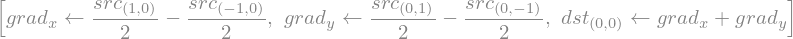

In [3]:
grad_x, grad_y = sp.symbols("grad_x, grad_y")

symbolic_description = [
    ps.Assignment(grad_x, (src[1, 0] - src[-1, 0]) / 2),
    ps.Assignment(grad_y, (src[0, 1] - src[0, -1]) / 2),
    ps.Assignment(dst[0, 0], grad_x + grad_y),
]
kernel = ps.create_kernel(symbolic_description)
symbolic_description

We created subexpressions, using standard sympy symbols on the left hand side, to split the kernel into multiple assignments. Defining a kernel using a list of `Assignment`s is quite tedious and hard to read. 
To simplify the formulation of a kernel, *pystencils* offers the `kernel` decorator, that transforms a normal Python function with `@=` assignments into an assignment list that can be passed to `create_kernel`. 

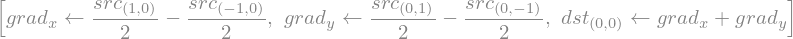

In [4]:
@ps.kernel
def symbolic_description_using_function():
    grad_x @= (src[1, 0] - src[-1, 0]) / 2
    grad_y @= (src[0, 1] - src[0, -1]) / 2
    dst[0, 0] @= grad_x + grad_y
symbolic_description_using_function

The decorated function can contain any Python code, only the `@=` operator, and the ternary inline `if-else` operator have different meaning. 

### b) Ternary 'if' with `Piecewise`

The ternary operator maps to `sympy.Piecewise` functions, that can be used to introduce branching into the kernel. Piecewise defined functions must give a value for every input, i.e. there must be a 'otherwise' clause in the end that is indicated by the condition `True`. Piecewise objects are standard sympy terms that can be integrated into bigger expressions:

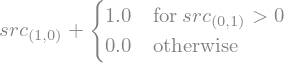

In [5]:
sp.Piecewise((1.0, src[0,1] > 0), (0.0, True)) + src[1, 0]

Piecewise objects are created by the `kernel` decorator for ternary if-else statements.

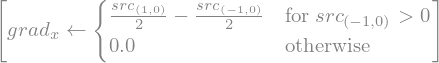

In [6]:
@ps.kernel
def kernel_with_piecewise():
    grad_x @= (src[1, 0] - src[-1, 0]) / 2 if src[-1, 0] > 0 else 0.0
kernel_with_piecewise

### c) Assignment level optimizations using `AssignmentCollection`

When the kernels get larger and more complex, it is helpful to organize the list of assignment into a more structured way. The `AssignmentCollection` offers optimizating transformation on a list of assignments. It holds two assignment lists, one for subexpressions and one for the main assignments. Main assignments are typically those that write to an array.

In [7]:
@ps.kernel
def somewhat_longer_dummy_kernel(s):
    s.a @= src[0, 1] + src[-1, 0]
    s.b @= 2 * src[1, 0] + src[0, -1]
    s.c @= src[0, 1] + 2 * src[1, 0] + src[-1, 0] + src[0, -1] - src[0,0]
    dst[0, 0] @= s.a + s.b + s.c
    
ac = ps.AssignmentCollection(main_assignments=somewhat_longer_dummy_kernel[-1:], 
                             subexpressions=somewhat_longer_dummy_kernel[:-1])
ac

"$$a \leftarrow {src}_{(0,1)} + {src}_{(-1,0)}$$"
"$$b \leftarrow 2 {src}_{(1,0)} + {src}_{(0,-1)}$$"
"$$c \leftarrow - {src}_{(0,0)} + 2 {src}_{(1,0)} + {src}_{(0,1)} + {src}_{(0,-1)} + {src}_{(-1,0)}$$"
"$${dst}_{(0,0)} \leftarrow a + b + c$$"


In [8]:
ac.operation_count

{'adds': 8,
 'muls': 2,
 'divs': 0,
 'sqrts': 0,
 'fast_sqrts': 0,
 'fast_inv_sqrts': 0,
 'fast_div': 0}

The `pystencils.simp` submodule offers several functions to optimize a collection of assignments.
It also offers functionality to group optimization into strategies and evaluate them. 
In this example we reduce the number of operations by reusing existing subexpressions to get rid of two unnecessary floating point additions. For more information about assignment collections and simplifications see the [demo notebook](demo_assignment_collection.ipynb).

In [9]:
opt_ac = ps.simp.subexpression_substitution_in_existing_subexpressions(ac)
opt_ac

"$$a \leftarrow {src}_{(0,1)} + {src}_{(-1,0)}$$"
"$$b \leftarrow 2 {src}_{(1,0)} + {src}_{(0,-1)}$$"
"$$c \leftarrow - {src}_{(0,0)} + a + b$$"
"$${dst}_{(0,0)} \leftarrow a + b + c$$"


In [10]:
opt_ac.operation_count

{'adds': 6,
 'muls': 1,
 'divs': 0,
 'sqrts': 0,
 'fast_sqrts': 0,
 'fast_inv_sqrts': 0,
 'fast_div': 0}

### d) Ghost layers and iteration region

When creating a kernel with neighbor accesses, *pystencils* automatically restricts the iteration region, such that all accesses are safe. 

In [11]:
kernel = ps.create_kernel(ps.Assignment(dst[0,0], src[2, 0] + src[-1, 0]))
ps.show_code(kernel)

FUNC_PREFIX void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 2; ctr_0 < 18; ctr_0 += 1)
   {
      double * RESTRICT _data_dst_00 = _data_dst + 30*ctr_0;
      double * RESTRICT _data_src_02 = _data_src + 30*ctr_0 + 60;
      double * RESTRICT _data_src_0m1 = _data_src + 30*ctr_0 - 30;
      for (int64_t ctr_1 = 2; ctr_1 < 28; ctr_1 += 1)
      {
         _data_dst_00[ctr_1] = _data_src_02[ctr_1] + _data_src_0m1[ctr_1];
      }
   }
}

When no additional ghost layer information is given, *pystencils* looks at all neighboring field accesses and introduces the required number of ghost layers **for all directions**. In the example above the largest neighbor accesses was ``src[2, 0]``, so theoretically we would need 2 ghost layers only the the end of the x coordinate. 
By default *pystencils* introduces 2 ghost layers at all borders of the domain. The next cell shows how to change this behavior. Be careful with manual ghost layer specification, wrong values may lead to SEGFAULTs.

In [12]:
gl_spec = [(0, 2),   # 0 ghost layers at the left, 2 at the right border
           (1, 0)]   # 1 ghost layer at the lower y, one at the upper y coordinate
kernel = ps.create_kernel(ps.Assignment(dst[0,0], src[2, 0] + src[-1, 0]), ghost_layers=gl_spec)
ps.show_code(kernel)

FUNC_PREFIX void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 0; ctr_0 < 18; ctr_0 += 1)
   {
      double * RESTRICT _data_dst_00 = _data_dst + 30*ctr_0;
      double * RESTRICT _data_src_02 = _data_src + 30*ctr_0 + 60;
      double * RESTRICT _data_src_0m1 = _data_src + 30*ctr_0 - 30;
      for (int64_t ctr_1 = 1; ctr_1 < 30; ctr_1 += 1)
      {
         _data_dst_00[ctr_1] = _data_src_02[ctr_1] + _data_src_0m1[ctr_1];
      }
   }
}

## 2 ) Restrictions


### a) Independence Restriction

*pystencils* only works for kernels where each array element can be updated independently from all other elements. This restriction ensures that the kernels can be easily parallelized and also be run on the GPU. Trying to define kernels where the results depends on the iteration order, leads to a ValueError.

In [13]:
invalid_description = [
    ps.Assignment(dst[1, 0], src[1, 0] + src[-1, 0]),
    ps.Assignment(dst[0, 0], src[1, 0] - src[-1, 0]),
]
try:
    invalid_kernel = ps.create_kernel(invalid_description)
    assert False, "Should never be executed"
except ValueError as e:
    print(e)

Field dst is written at two different locations


The independence restriction makes sure that the kernel can be safely parallelized by checking the following conditions: If a field is modified inside the kernel, it may only be modified at a single spatial position. In that case the field may also only be read at this position. Fields that are not modified may be read at multiple neighboring positions.

Specifically, this rule allows for in-place updates that don't access neighbors.

In [14]:
valid_kernel = ps.create_kernel(ps.Assignment(src[0,0], 2*src[0,0] + 42))

If a field stores multiple values per cell, as in the next example, this restriction only applies for accesses with the same index.

In [15]:
v = ps.fields("v(2): double[2D]")
valid_kernel = ps.create_kernel([ps.Assignment(v[0,0](1), 2*v[0,0](1) + 42),
                                 ps.Assignment(v[0,1](0), 2*v[1,0](0) + 42)])

### b) Static Single Assignment Form

All assignments that don't write to a field must be in SSA form
1. Each sympy symbol may only occur once as a left-hand-side (fields can be written multiple times)
2. A symbol has to be defined before it is used. If it is never defined it is introduced as function parameter

The next cell demonstrates the first SSA restriction:

In [16]:
@ps.kernel
def not_allowed():
    a, b = sp.symbols("a b")
    a @= src[0, 0]
    b @= a + 3
    a @= src[-1, 0]
    dst[0, 0] @= a + b
try:
    ps.create_kernel(not_allowed)
    assert False
except ValueError as e:
    print(e)

Assignments not in SSA form, multiple assignments to a


However, for right hand sides that are Field.Accesses this is allowed:

In [17]:
@ps.kernel
def allowed():
    dst[0, 0] @= src[0, 1] + src[1, 0]
    dst[0, 0] @= 2 * dst[0, 0]
ps.create_kernel(allowed)

KernelFunction kernel([_data_dst, _data_src])